In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
from functools import reduce
from typing import NamedTuple, Sequence

In [2]:
Note = NamedTuple("Note", [("x", datetime.datetime), ("y", float), ("s", str)])

def pivot_df_pm25(df: pd.DataFrame, start_incl: datetime.datetime, end_excl: datetime.datetime) -> pd.DataFrame:
    times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
    df_within_time = df.reset_index(level=0, drop=True).loc[times, :]
    df_grouped = df_within_time.groupby(["Floor", "Location"])
    dfs = [grp[["PM2.5(ug/m³)"]].rename(columns={"PM2.5(ug/m³)": f"L{floor}_{location.replace(" ", "_")}"}) for (floor, location), grp in df_grouped]
    return reduce(lambda l, r: l.join(r), dfs)

def display_data_overview(
    df: pd.DataFrame, notes: Sequence[Note], start_incl: datetime.datetime, end_excl: datetime.datetime
):
    pm25_df = pivot_df_pm25(df, start_incl, end_excl)
    # display(pm25_df)
    ax = pm25_df.resample("5min").interpolate(method="akima").plot(ylabel="PM₂.₅ (µg/m³)")
    # default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # for field, color in list(zip(pm25_df, default_colors)):
    #     pm25_df.reset_index().plot.scatter(["Time"], [field], c=color, marker="x", xlabel="Time", ylabel="PM₂.₅ (µg/m³)", ax=ax)
    for note in notes:
        ax.text(*note)

def display_correlation(df: pd.DataFrame, tgt: str, src: str, start_incl: datetime.datetime, end_excl: datetime.datetime):
    pm25_df = pivot_df_pm25(df, start_incl, end_excl)
    regression = sm.ols(formula=f"{tgt} ~ {src} -1", data=pm25_df).fit()
    coefficient = regression.params.values[0]
    max_src = pm25_df[src].max()
    ax = pm25_df.plot.scatter(tgt, src)
    ax.plot([0, max_src * coefficient], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=0, y=1, s=f"{tgt} = {src} ÷ {1 / coefficient:.4f} (r²={regression.rsquared:.4f})")

def display_correlation2(df: pd.DataFrame, tgt: str, src: str, start_incl: datetime.datetime, end_excl: datetime.datetime):
    pm25_df = pivot_df_pm25(df, start_incl, end_excl)
    regression = sm.ols(formula=f"{tgt} ~ {src} -0", data=pm25_df).fit()
    [intercept, coefficient] = regression.params.values
    max_src = pm25_df[src].max()
    max_pred_tgt = max_src * coefficient + intercept
    ax = pm25_df.plot.scatter(tgt, src)
    ax.plot([intercept, max_pred_tgt], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=2, y=0.5, s=f"{tgt} = {intercept:.4f} + {src} ÷ {1 / coefficient:.4f} (r²={regression.rsquared:.4f})")
    ax.set_xlim(left=0.25)


In [3]:
%run "Common.ipynb"

Time                                   Floor  \
                             min                       max count nunique   
Device                                                                     
01     2024-08-18 17:00:00+08:00 2024-08-23 14:00:00+08:00   111       1   
02     2024-08-18 17:00:00+08:00 2024-08-23 14:00:00+08:00   112       1   
03     2024-08-17 20:00:00+08:00 2024-08-23 14:00:00+08:00   129       1   

       Location  
        nunique  
Device           
01            2  
02            3  
03            3

# Overview
This chart plots the PM<sub>2.5</sub> values in the Trellis 2nd floor (the `L2`) patio (`L2_Patio`), west hallway (`L2_West_Hallway`), and the inside of unit 210 (`L2_Unit_210`), starting from August 21, 4am until now. At the start of this time window, the hallway ventilation had been shut off for a little over 40 hours (since August 19, 9am).

Some points of interest:
- On August 21, between 8 and 9am, the ventilation was briefly turned on. Notice that `L2_West_Hallway`, which is generally a little less contaminated than `L2_Unit_210` skyrocketed.
- 2-3 hours later, around 12 noon, the ventilation was turned back off, and the PM<sub>2.5</sub> numbers gradually came back down.
- On August 22, around noon, Unit 210 windows were shut (stopping the intake of outside air). `L2_Unit_210`, which had been slightly more contaminated than `L2_West_Hallway`, immediately improves to be cleaner than `L2_West_Hallway`. The A/C unit was running during the day, but not at night.

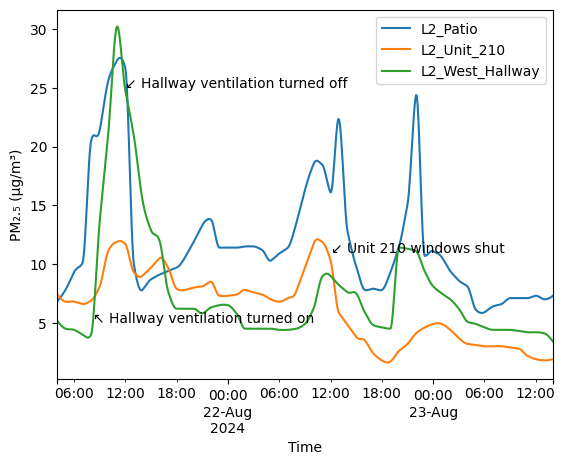

In [4]:
display_data_overview(
    df,
    notes=[
        Note(x=datetime.datetime.fromisoformat("2024-08-21T08:15:00+08.00"), y=5, s="↖ Hallway ventilation turned on"),
        Note(x=datetime.datetime.fromisoformat("2024-08-21T12:00:00+08.00"), y=25, s="↙ Hallway ventilation turned off"),
        Note(x=datetime.datetime.fromisoformat("2024-08-22T12:00:00+08.00"), y=11, s="↙ Unit 210 windows shut"),
    ],
    start_incl=datetime.datetime.fromisoformat("2024-08-21T04:00:00+08.00"),
    end_excl=datetime.datetime.fromisoformat("2024-08-23T15:00:00+08.00")
)

## Comparing Patio and West Hallway
This plot compares `L2_Patio`, and `L2_West_Hallway`, during the time when the hallway ventilation was shut off. And shows that on average, west hallway air has about 56% of the contaminants of the patio air.

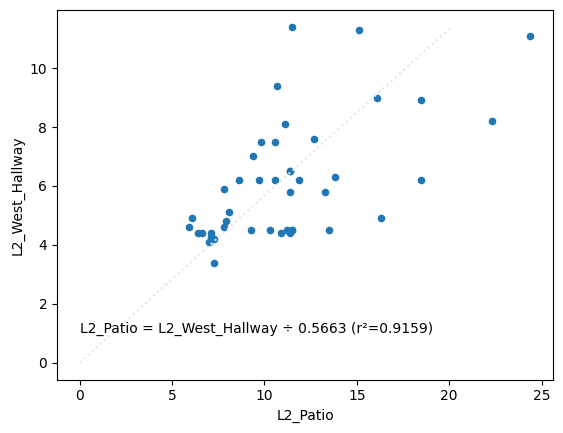

In [5]:
display_correlation(
    df, tgt="L2_Patio", src="L2_West_Hallway",
    start_incl=datetime.datetime.fromisoformat("2024-08-21T18:00:00+08.00"),
    end_excl=datetime.datetime.fromisoformat("2024-08-23T15:00:00+08.00")
)

## Comparing West Hallway and Unit 210
The next two plots compares `L2_West_Hallway` and `L2_Unit_210`, it focuses on the period after August 21, 6pm (after the ventilation had been turned off, and the air quality has had some time to normalize), and compares the period before and after August 22, 12 noon, when the windows were shut.

Before the windows were shut, Unit 210 air has ~147% the contaminents of West Hallway air. After, it drops almost immediately to ~54%.

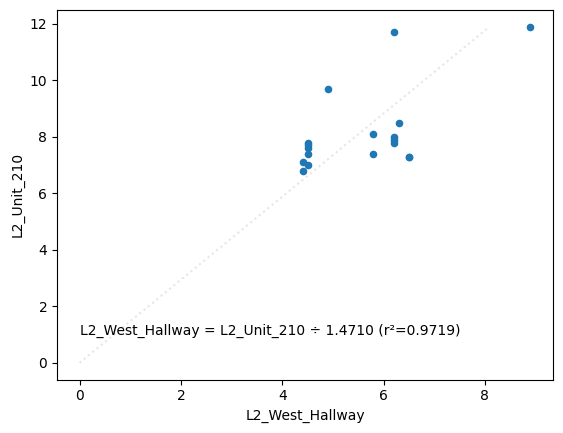

In [6]:
display_correlation(
    df, tgt="L2_West_Hallway", src="L2_Unit_210",
    start_incl=datetime.datetime.fromisoformat("2024-08-21T18:00:00+08.00"),
    end_excl=datetime.datetime.fromisoformat("2024-08-22T12:00:00+08.00")
)

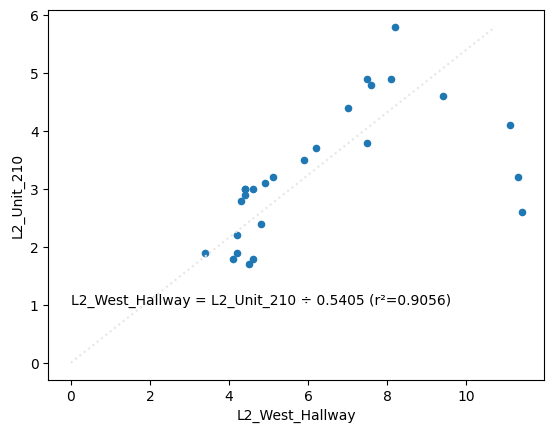

In [7]:
display_correlation(
    df, tgt="L2_West_Hallway", src="L2_Unit_210",
    start_incl=datetime.datetime.fromisoformat("2024-08-22T13:00:00+08.00"),
    end_excl=datetime.datetime.fromisoformat("2024-08-23T15:00:00+08.00")
)